In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio

In [2]:
vidpath = 'cat.mp4'

In [3]:
# prompt: load a single frame of a video file

def load_single_frame(video_path, frame_number):
  """Loads a single frame from a video file.

  Args:
    video_path: Path to the video file.
    frame_number: The frame number to load (0-indexed).

  Returns:
    A NumPy array representing the frame, or None if the frame
    number is invalid or the file cannot be opened.
  """
  try:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print(f"Error opening video file: {video_path}")
      return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if not 0 <= frame_number < total_frames:
      print(f"Invalid frame number: {frame_number}. Total frames: {total_frames}")
      return None

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Error reading frame {frame_number}")
        return None
  except Exception as e:
    print(f"An error occurred: {e}")
    return None


Click in the window to select TOP‑LEFT, TOP‑RIGHT, BOTTOM‑RIGHT, BOTTOM‑LEFT (in that order).
Selected corners (row, col):
[[  90  330]
 [ 104 1516]
 [1043 1507]
 [1073  347]]


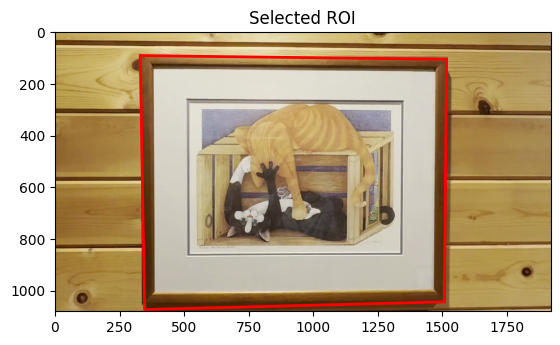

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your first frame as before
frame0 = load_single_frame(vidpath, 0)   # shape (H, W, 3), RGB in [0,1]

# Prepare for interactive picking
points = []
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x, y))
        # draw a small circle so you see your click
        cv2.circle(frame_disp, (x, y), 5, (0, 255, 0), -1)

# Convert to BGR uint8 for cv2 display
frame_disp = cv2.cvtColor((frame0 * 255).astype('uint8'), cv2.COLOR_RGB2BGR)
win = "Select 4 corners: TL → TR → BR → BL"
cv2.namedWindow(win)
cv2.setMouseCallback(win, mouse_callback)

print("Click in the window to select TOP‑LEFT, TOP‑RIGHT, BOTTOM‑RIGHT, BOTTOM‑LEFT (in that order).")

# Show window and wait until 4 clicks
while True:
    cv2.imshow(win, frame_disp)
    if len(points) == 4:
        break
    # small delay so CPU isn’t pegged
    if cv2.waitKey(50) & 0xFF == 27:  # allow Esc to abort early
        break

cv2.destroyAllWindows()

# Convert collected (x,y) to (row, col) array
corners = np.array([[y, x] for (x, y) in points])  # shape (4,2)

print("Selected corners (row, col):")
print(corners)

# ──────── 2. REST OF THE PIPELINE (unchanged) ────────
# width = horizontal span (x‑axis = column index)
width  = int(max(abs(corners[1,1] - corners[0,1]),   # top edge
                 abs(corners[2,1] - corners[3,1])))  # bottom edge

# height = vertical span (y‑axis = row index)
height = int(max(abs(corners[3,0] - corners[0,0]),   # left edge
                 abs(corners[2,0] - corners[1,0])))  # right edge

rectcorners = np.array([[0, 0],
                        [0, width],
                        [height, width],
                        [height, 0]])

# visualize the region you picked
plt.imshow(frame0)
plt.fill(corners[:,1], corners[:,0],
         edgecolor='red', lw=2, facecolor='none')
plt.title("Selected ROI")
plt.show()


In [5]:
# Rectify Original Image
def rectify(img, incorners, outcorners):
  outsize = (outcorners[2, 1], outcorners[2, 0])
  H, m = cv2.findHomography(incorners[:,::-1], outcorners[:,::-1], cv2.RANSAC) # uses col,row order
  outimg = cv2.warpPerspective(img, H, outsize)
  return outimg

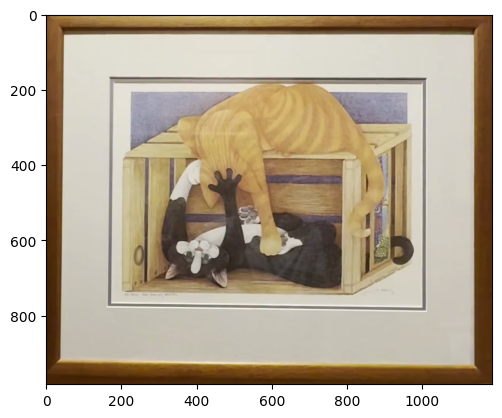

In [6]:
# show original rectified image
refimg = rectify(frame0, corners, rectcorners)
plt.imshow(refimg)
plt.show()

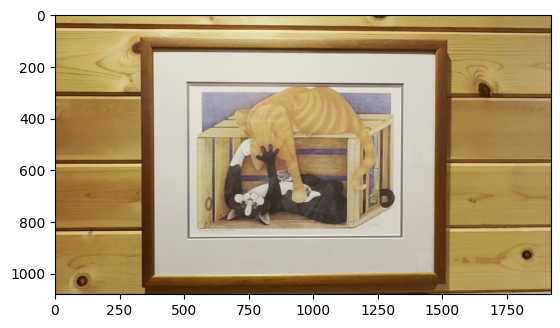

In [17]:
# load another frame
frame1 = load_single_frame(vidpath, 1)
plt.imshow(frame1)
plt.show()

In [18]:
def find_homography(img0, img1):
  gray0 = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
  gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

  orb = cv2.ORB_create()
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  kp0, des0 = orb.detectAndCompute(gray0, None)
  kp1, des1 = orb.detectAndCompute(gray1, None)

  matches = bf.match(des0, des1)
  matches = sorted(matches, key = lambda x:x.distance)

  src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  des_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  H, m = cv2.findHomography(src_pts, des_pts, cv2.RANSAC, 5.0)

  return H

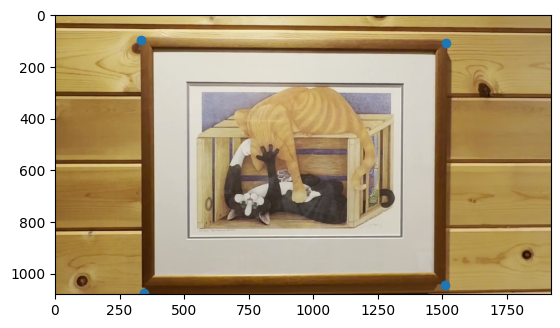

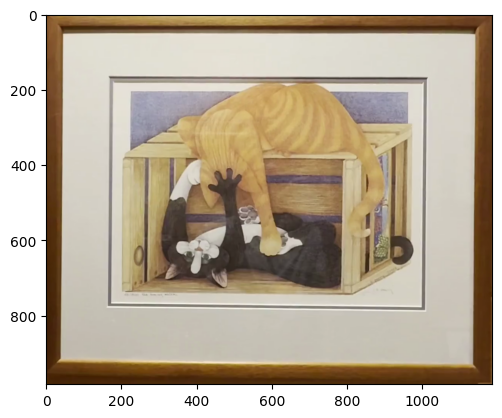

In [19]:
# warp new frame to rectified space
H = find_homography(refimg, frame1)

# change to both xy and column format
newcorners = cv2.perspectiveTransform(np.float32(rectcorners[:, ::-1].reshape(-1, 1, 2)), H)

# show new corners
plt.imshow(frame1)
plt.scatter(newcorners[:,:,0], newcorners[:,:,1])
plt.show()

# show rectified image
rectimg = rectify(frame1, newcorners, rectcorners)
plt.imshow(rectimg)
plt.show()

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


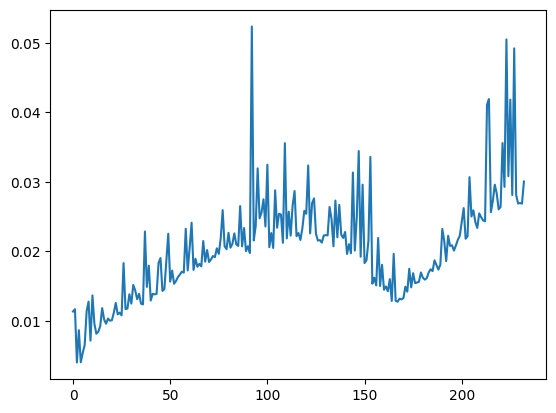

: 

In [ ]:
# plot total absolute pixel difference for each frame of the video
incr = 1
frame_ixs = range(0,233,incr)
nframes = len(frame_ixs)

error = np.zeros(nframes)
imgs = np.zeros([nframes, height, width, 3])
for i, fi in enumerate(frame_ixs):
  if i % 10 == 0:
    print('.')
  fimg = load_single_frame(vidpath, fi)
  H = find_homography(refimg, fimg)
  newcorners = cv2.perspectiveTransform(np.float32(rectcorners[:, ::-1].reshape(-1, 1, 2)), H)
  rectimg = rectify(fimg, newcorners, rectcorners)

  error[i] = np.mean(np.abs(np.float64(refimg)/255.-np.float64(rectimg)/255.))
  imgs[i] = rectimg

plt.plot(error)
plt.show()

In [17]:
with imageio.get_writer("vegetables_inc3.gif", mode="I") as writer:
  for idx, frame in enumerate(imgs):
    print("Adding frame to GIF file: ", idx + 1)
    writer.append_data(np.uint8(frame))

Adding frame to GIF file:  1
Adding frame to GIF file:  2
Adding frame to GIF file:  3
Adding frame to GIF file:  4
Adding frame to GIF file:  5
Adding frame to GIF file:  6
Adding frame to GIF file:  7
Adding frame to GIF file:  8
Adding frame to GIF file:  9
Adding frame to GIF file:  10
Adding frame to GIF file:  11
Adding frame to GIF file:  12
Adding frame to GIF file:  13
Adding frame to GIF file:  14
Adding frame to GIF file:  15
Adding frame to GIF file:  16
Adding frame to GIF file:  17
Adding frame to GIF file:  18
Adding frame to GIF file:  19
Adding frame to GIF file:  20
Adding frame to GIF file:  21
Adding frame to GIF file:  22
Adding frame to GIF file:  23
Adding frame to GIF file:  24
Adding frame to GIF file:  25
Adding frame to GIF file:  26
Adding frame to GIF file:  27
Adding frame to GIF file:  28
Adding frame to GIF file:  29
Adding frame to GIF file:  30
Adding frame to GIF file:  31
Adding frame to GIF file:  32
Adding frame to GIF file:  33
Adding frame to GIF

In [ ]:
import cv2, numpy as np

height, width = imgs[0].shape[:2]
fps      = 30
out_path = "rectified_video.mp4"
fourcc   = cv2.VideoWriter_fourcc(*"mp4v")   # or "XVID" for .avi

writer = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

for idx, frame in enumerate(imgs):
    print(f"Writing frame {idx + 1}/{len(imgs)}")
    bgr = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    writer.write(bgr)

writer.release()
print("✓  Video written to", out_path)


Writing frame 1/78
Writing frame 2/78
Writing frame 3/78
Writing frame 4/78
Writing frame 5/78
Writing frame 6/78
Writing frame 7/78
Writing frame 8/78
Writing frame 9/78
Writing frame 10/78
Writing frame 11/78
Writing frame 12/78
Writing frame 13/78
Writing frame 14/78
Writing frame 15/78
Writing frame 16/78
Writing frame 17/78
Writing frame 18/78
Writing frame 19/78
Writing frame 20/78
Writing frame 21/78
Writing frame 22/78
Writing frame 23/78
Writing frame 24/78
Writing frame 25/78
Writing frame 26/78
Writing frame 27/78
Writing frame 28/78
Writing frame 29/78
Writing frame 30/78
Writing frame 31/78
Writing frame 32/78
Writing frame 33/78
Writing frame 34/78
Writing frame 35/78
Writing frame 36/78
Writing frame 37/78
Writing frame 38/78
Writing frame 39/78
Writing frame 40/78
Writing frame 41/78
Writing frame 42/78
Writing frame 43/78
Writing frame 44/78
Writing frame 45/78
Writing frame 46/78
Writing frame 47/78
Writing frame 48/78
Writing frame 49/78
Writing frame 50/78
Writing f

: 

In [12]:
import sys
sys.path.append('../')
from data_read import *
from net import *
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

parser = argparse.ArgumentParser()


parser.add_argument('--dataset_name', action="store", dest= "dataset_name",default="MSCOCO",help='MSCOCO,GoogleMap,GoogleEarth,DayNight')


parser.add_argument('--epoch_load_one', action="store", dest="epoch_load_one", type=int, default=3,help='epoch_load_one')


parser.add_argument('--epoch_load_two', action="store", dest="epoch_load_two", type=int, default=3,help='epoch_load_two')

parser.add_argument('--epoch_load_three', action="store", dest="epoch_load_three", type=int, default=3,help='epoch_load_three')

parser.add_argument('--num_iters', action="store", dest="num_iters", type=int, default=20,help='num_iters')

parser.add_argument('--feature_map_type', action="store", dest="feature_map_type", default='special',help='regular or special')

parser.add_argument('--initial_type', action="store", dest="initial_type", default='multi_net',help='vanilla, simple_net, multi_net')

parser.add_argument('--load_epoch_simplenet', action="store", dest="load_epoch_simplenet", default=50,help='load_epoch_simplenet')

parser.add_argument('--load_epoch_multinet', action="store", dest="load_epoch_multinet", default=[50,50,40],help='load_epoch_multinet')


input_parameters = parser.parse_args([])



gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)



def construct_matrix_regression(batch_size,network_output,network_output_2=[0]):
    extra=tf.ones((batch_size,1))
    predicted_matrix=tf.concat([network_output,extra],axis=-1)
    predicted_matrix=tf.reshape(predicted_matrix,[batch_size,3,3])
    if len(np.shape(network_output_2))>1:
        predicted_matrix_2=tf.concat([network_output_2,extra],axis=-1)
        predicted_matrix_2=tf.reshape(predicted_matrix_2,[batch_size,3,3])
    hh_matrix=[]
    for i in range(batch_size):
        if len(np.shape(network_output_2))>1:
            hh_matrix.append(np.linalg.inv(np.dot(predicted_matrix_2[i,:,:],predicted_matrix[i,:,:])))
        else:
            hh_matrix.append(np.linalg.inv(predicted_matrix[i,:,:]))
        #hh_matrix.append(predicted_matrix[i,:,:])
    
    #return tf.linalg.inv(predicted_matrix+0.0001)
    return np.asarray(hh_matrix)

def initial_motion_COCO():
    # prepare source and target four points
    matrix_list=[]
    for i in range(1):
       
        src_points=[[0,0],[127,0],[127,127],[0,127]]

        tgt_points=[[32,32],[160,32],[160,160],[32,160]]

    
        src_points=np.reshape(src_points,[4,1,2])
        tgt_points=np.reshape(tgt_points,[4,1,2])

        # find homography
        h_matrix, status = cv2.findHomography(src_points, tgt_points,0)
        matrix_list.append(h_matrix)
    return np.asarray(matrix_list).astype(np.float32)


def construct_matrix(initial_matrix,scale_factor,batch_size):
    #scale_factor size_now/(size to get matrix)
    initial_matrix=tf.cast(initial_matrix,dtype=tf.float32)
    
    scale_matrix=np.eye(3)*scale_factor
    scale_matrix[2,2]=1.0
    scale_matrix=tf.cast(scale_matrix,dtype=tf.float32)
    scale_matrix_inverse=tf.linalg.inv(scale_matrix)

    scale_matrix=tf.expand_dims(scale_matrix,axis=0)
    scale_matrix=tf.tile(scale_matrix,[batch_size,1,1])

    scale_matrix_inverse=tf.expand_dims(scale_matrix_inverse,axis=0)
    scale_matrix_inverse=tf.tile(scale_matrix_inverse,[batch_size,1,1])

    final_matrix=tf.matmul(tf.matmul(scale_matrix,initial_matrix),scale_matrix_inverse)
    return final_matrix



def average_cornner_error(batch_size,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127):
    
    four_conner=[[top_left_u,top_left_v,1],[bottom_right_u,top_left_v,1],[bottom_right_u,bottom_right_v,1],[top_left_u,bottom_right_v,1]]
    four_conner=np.asarray(four_conner)
    four_conner=np.transpose(four_conner)
    four_conner=np.expand_dims(four_conner,axis=0)
    four_conner=np.tile(four_conner,[batch_size,1,1]).astype(np.float32)
    
    new_four_points=tf.matmul(predicted_matrix,four_conner)
    
    new_four_points_scale=new_four_points[:,2:,:]
    new_four_points= new_four_points/new_four_points_scale
    
    
    u_predict=new_four_points[:,0,:]
    v_predict=new_four_points[:,1,:]
    
    average_conner=tf.reduce_mean(tf.sqrt(tf.math.pow(u_predict-u_list,2)+tf.math.pow(v_predict-v_list,2)))

    
    
    return average_conner
    

def calculate_feature_map(input_tensor):
    bs,height,width,channel=tf.shape(input_tensor)
    path_extracted=tf.image.extract_patches(input_tensor, sizes=(1,3,3,1), strides=(1,1,1,1), rates=(1,1,1,1), padding='SAME')
    path_extracted=tf.reshape(path_extracted,(bs,height,width,channel,9))
    path_extracted_mean=tf.math.reduce_mean(path_extracted,axis=3,keepdims=True)

    #path_extracted_mean=tf.tile(path_extracted_mean,[1,1,1,channel,1])
    path_extracted=path_extracted-path_extracted_mean
    path_extracted_transpose=tf.transpose(path_extracted,(0,1,2,4,3))
    variance_matrix=tf.matmul(path_extracted_transpose,path_extracted)
    
    tracevalue=tf.linalg.trace(variance_matrix)
    row_sum=tf.reduce_sum(variance_matrix,axis=-1)
    max_row_sum=tf.math.reduce_max(row_sum,axis=-1)
    min_row_sum=tf.math.reduce_min(row_sum,axis=-1)
    mimic_ratio=(max_row_sum+min_row_sum)/2.0/tracevalue
    
    return  tf.expand_dims(mimic_ratio,axis=-1)


if input_parameters.feature_map_type=='regular':
    load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one_regular/'

    load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two_regular/'

    load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three_regular/'

    level_one_input=ResNet_first_input(if_regular=True)
    level_one_template=ResNet_first_template(if_regular=True)
    level_two_input=ResNet_second_input(if_regular=True)
    level_two_template=ResNet_second_template(if_regular=True)
    level_three_input=ResNet_third_input(if_regular=True)
    level_three_template=ResNet_third_template(if_regular=True)

elif input_parameters.feature_map_type=='special':

    load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one/'

    load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two/'

    load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three/'

    level_one_input=ResNet_first_input()
    level_one_template=ResNet_first_template()
    level_two_input=ResNet_second_input()
    level_two_template=ResNet_second_template()
    level_three_input=ResNet_third_input()
    level_three_template=ResNet_third_template()


level_one_input.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"input_full")

level_one_template.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"template_full")

level_two_input.load_weights(load_path_two + 'epoch_'+str(input_parameters.epoch_load_two)+"input_full")

level_two_template.load_weights(load_path_two  + 'epoch_'+str(input_parameters.epoch_load_two)+"template_full")

level_three_input.load_weights(load_path_three + 'epoch_'+str(input_parameters.epoch_load_three)+"input_full")

level_three_template.load_weights(load_path_three  + 'epoch_'+str(input_parameters.epoch_load_three)+"template_full")


if input_parameters.initial_type=='vanilla':
    initial_matrix=initial_motion_COCO()
    initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)

if input_parameters.initial_type=='simple_net':
    save_path_regression='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_1/'
    regression_network=Net_first()
    regression_network.load_weights(save_path_regression + 'epoch_'+str(input_parameters.load_epoch_simplenet))

if input_parameters.initial_type=='multi_net':
    save_path_one='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_1/'
    save_path_two='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_2/'
    save_path_three='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_3/'
    regression_network_one=Net_first()
    regression_network_one.load_weights(save_path_one + 'epoch_'+str(input_parameters.load_epoch_multinet[0]))
    regression_network_two=Net_second()
    regression_network_two.load_weights(save_path_two + 'epoch_'+str(input_parameters.load_epoch_multinet[1]))
    regression_network_three=Net_third()
    regression_network_three.load_weights(save_path_three + 'epoch_'+str(input_parameters.load_epoch_multinet[2]))
    

LK_layer_one=Lucas_Kanade_layer(batch_size=1,height_template=128,width_template=128,num_channels=1)

LK_layer_two=Lucas_Kanade_layer(batch_size=1,height_template=64,width_template=64,num_channels=1)

LK_layer_three=Lucas_Kanade_layer(batch_size=1,height_template=32,width_template=32,num_channels=1)


LK_layer_regression=Lucas_Kanade_layer(batch_size=1,height_template=192,width_template=192,num_channels=3)


if input_parameters.dataset_name=='MSCOCO':
    data_loader_caller=data_loader_MSCOCO('val')

if input_parameters.dataset_name=='GoogleMap':
    data_loader_caller=data_loader_GoogleMap('val')

if input_parameters.dataset_name=='GoogleEarth':
    data_loader_caller=data_loader_GoogleEarth('val')

if input_parameters.dataset_name=='DayNight':
    data_loader_caller=data_loader_DayNight('val')

1 Physical GPUs, 1 Logical GPUs


2025-07-17 00:24:38.117979: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-07-17 00:24:38.117996: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-17 00:24:38.117999: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-07-17 00:24:38.118055: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-17 00:24:38.118228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


6387


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from skimage.transform import resize
import cv2

# --- YOUR MANUAL IMAGE LOADING AND PREPROCESSING CODE STARTS HERE ---
# 📸 IMPORTANT: Replace 'path/to/your/video.mp4' with your actual video path
vidpath = 'path/to/your/video.mp4'

# Open video to query frame count and load frame 0 as the template
try:
    cap = cv2.VideoCapture(vidpath)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video file {vidpath}")
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    print(f"Total frames in video: {total_frames}")

    raw_template_img = load_single_frame(vidpath, 0)  # H×W×3 normalized in [0,1]
    print(f"Loaded original template frame shape: {raw_template_img.shape}")

except FileNotFoundError:
    print("Error: Video file not found or could not read frame 0. Please check the path.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading the template frame: {e}")
    exit()

# Ensure template has 3 channels
if raw_template_img.ndim == 2:
    raw_template_img = np.stack([raw_template_img]*3, axis=-1)

# Resize template to 128×128 (as per model expectations)
target_template_dim = (128, 128)
template_img_resized = resize(raw_template_img, target_template_dim, anti_aliasing=True)
print(f"Resized template image for feature extraction shape: {template_img_resized.shape}")

# Convert template to TensorFlow tensor and add batch dimension
template_img_tf_batch = tf.expand_dims(
    tf.convert_to_tensor(template_img_resized, dtype=tf.float32),
    axis=0
)

# Prepare template for initial regression network
template_img_padded_for_regression = tf.image.pad_to_bounding_box(
    template_img_tf_batch, 32, 32, 192, 192
)
template_img_grey_for_regression = tf.image.rgb_to_grayscale(
    template_img_padded_for_regression
)

# --- END OF YOUR MANUAL IMAGE LOADING AND PREPROCESSING CODE ---

# --- MODIFIED PIPELINE EXECUTION ---
total_error = 0.0
fk_loop     = input_parameters.num_iters
u_list_manual = np.array([[0, 127, 127, 0]])   # Placeholder corner u’s
v_list_manual = np.array([[0,   0, 127, 127]]) # Placeholder corner v’s

for idx in range(1, total_frames):
    # Load & normalize the current input frame
    raw_input_img = load_single_frame(vidpath, idx)
    if raw_input_img.ndim == 2:
        raw_input_img = np.stack([raw_input_img]*3, axis=-1)
    input_img_resized = resize(raw_input_img, (192, 192), anti_aliasing=True)
    print(f"\nFrame {idx}: resized input shape = {input_img_resized.shape}")

    # Convert to TensorFlow tensor + batch
    input_img_tf_batch = tf.expand_dims(
        tf.convert_to_tensor(input_img_resized, dtype=tf.float32),
        axis=0
    )

    # Prepare input for initial regression network
    input_img_grey_for_regression = tf.image.rgb_to_grayscale(input_img_tf_batch)
    network_input_for_regression_models = tf.concat([
        template_img_grey_for_regression,
        input_img_grey_for_regression
    ], axis=-1)
    print(f"Shape of prepared input for regression models: {network_input_for_regression_models.shape}")

    # INITIALIZATION via your chosen net
    if input_parameters.initial_type == 'simple_net':
        homography_vector = regression_network.call(
            network_input_for_regression_models,
            training=False
        )
        extra = tf.ones((1, 1))
        initial_matrix = tf.concat([homography_vector, extra], axis=-1)
        initial_matrix = tf.reshape(initial_matrix, [1, 3, 3])
        initial_matrix = construct_matrix(
            initial_matrix,
            scale_factor=0.25,
            batch_size=1
        )

    else:  # multi_net
        # 1st net
        v1 = regression_network_one.call(
            network_input_for_regression_models,
            training=False
        )
        M1 = construct_matrix_regression(1, v1)
        warp1 = LK_layer_regression.projective_inverse_warp(
            tf.cast(input_img_tf_batch, tf.float32), M1
        )
        g1 = tf.image.rgb_to_grayscale(warp1)

        # 2nd net
        x2 = tf.concat([g1, input_img_grey_for_regression], axis=-1)
        v2 = regression_network_two.call(x2, training=False)
        M2 = construct_matrix_regression(1, v1, v2)
        warp2 = LK_layer_regression.projective_inverse_warp(
            tf.cast(input_img_tf_batch, tf.float32), M2
        )
        g2 = tf.image.rgb_to_grayscale(warp2)

        # 3rd net
        x3 = tf.concat([g2, input_img_grey_for_regression], axis=-1)
        v3 = regression_network_three.call(x3, training=False)

        extra = tf.ones((1, 1))
        mat3 = tf.concat([v3, extra], axis=-1)
        mat3 = tf.reshape(mat3, [1, 3, 3])
        composed = np.dot(mat3[0], np.linalg.inv(M2[0]))
        init = np.expand_dims(composed, axis=0)
        initial_matrix = construct_matrix(
            init,
            scale_factor=0.25,
            batch_size=1
        )

    # FEATURE EXTRACTION
    f1_in = level_one_input.call(input_img_tf_batch,      training=False)
    f2_in = level_two_input.call(f1_in,                   training=False)
    f3_in = level_three_input.call(f2_in,                 training=False)

    if input_parameters.feature_map_type == 'regular':
        map1_in, map2_in, map3_in = f1_in, f2_in, f3_in
    else:
        map1_in = calculate_feature_map(f1_in)
        map2_in = calculate_feature_map(f2_in)
        map3_in = calculate_feature_map(f3_in)

    # DEEP LUCAS–KANADE REFINEMENT
    updated_matrix = initial_matrix
    for _ in range(fk_loop):
        updated_matrix = LK_layer_three.update_matrix(tmpl_map3, map3_in, updated_matrix)
    updated_matrix = construct_matrix(updated_matrix, scale_factor=2.0, batch_size=1)
    for _ in range(fk_loop):
        updated_matrix = LK_layer_two.update_matrix(tmpl_map2, map2_in, updated_matrix)
    updated_matrix = construct_matrix(updated_matrix, scale_factor=2.0, batch_size=1)
    for _ in range(fk_loop):
        updated_matrix = LK_layer_one.update_matrix(tmpl_map1, map1_in, updated_matrix)

    # METRICS & OUTPUT
    predicted_matrix = updated_matrix
    cornner_error = average_cornner_error(
        1, predicted_matrix,
        u_list_manual, v_list_manual,
        top_left_u=0, top_left_v=0,
        bottom_right_u=127, bottom_right_v=127
    )

    print(f"Corner error = {float(cornner_error):.4f}")
    print("Predicted homography:\n", predicted_matrix.numpy()[0])


Total frames in video: 249
Frame   1 → corner error = 105.3481
Homography:
 [[ 1.6728872e+00  2.3894717e-01  1.5957700e+00]
 [-7.3444381e-02  4.3079090e+00 -1.4727995e+02]
 [ 1.2943003e-03  7.9595875e-03  1.0000000e+00]] 

Frame   2 → corner error = 92.2281
Homography:
 [[ 1.5683148e+00  1.8627088e-01  3.8168817e+00]
 [-2.2469464e-01  3.7983820e+00 -1.1326284e+02]
 [ 1.2756964e-03  6.4273505e-03  1.0000000e+00]] 

Frame   3 → corner error = 51.3283
Homography:
 [[ 8.6183536e-01 -3.1850907e-01  3.2717438e+01]
 [-5.0517291e-01  7.5603688e-01  5.5784393e+01]
 [ 9.5683226e-04 -3.0139782e-03  1.0000000e+00]] 

Frame   4 → corner error = 54.3392
Homography:
 [[ 6.5984720e-01 -5.4513019e-01  5.9821930e+01]
 [ 2.3027217e-02  8.5511100e-01  8.7401962e+00]
 [ 7.5200025e-04 -3.5057061e-03  1.0000000e+00]] 

Frame   5 → corner error = 55.0829
Homography:
 [[ 6.7596263e-01 -5.7331133e-01  6.2480000e+01]
 [ 2.5069101e-02  8.8623780e-01  8.4356709e+00]
 [ 9.5974957e-04 -3.4284408e-03  1.0000000e+00]]